# Install

In [1]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Import and set directory

In [6]:
import os
import time
import torch
import tempfile
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_2d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

In [9]:
directory_path = '/kaggle/working/prova_cerchi_dir'
os.makedirs(directory_path)
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

In [10]:
!tree /kaggle

/kaggle
|-- input
|-- lib
|   `-- kaggle
|       `-- gcp.py
`-- working
    `-- prova_cerchi_dir

5 directories, 1 file


# Function definition

In [36]:
def create_image_2d (n_train, n_test, noise, r_min, r_max, seed):
  np.random.seed(seed)

  for i in range(n_train + n_test):
    image, label = create_test_image_2d(128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
    Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.png")))
  labels = sorted(glob(os.path.join(root_dir, "label*.png")))
  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [12]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [13]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    spatial_dims = 2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels  = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels  = [post_trans(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_outputs = model(val_input)
    val_outputs = post_trans(val_outputs[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title("Image")
    ax1.imshow(val_ds[i]["image"][0, :, :].detach().cpu(), cmap="gray")

    ax2.set_title("Label")
    ax2.imshow(val_ds[i]["label"][0, :, :].detach().cpu())

    ax3.set_title("Output")
    ax3.imshow(val_outputs[0, :, :].detach().cpu())

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [48]:
def plot_train_dim(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, 'plot_train_dim.png')

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(n_train_vec, metric_test, label = 'Test metric', marker='*')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimention")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimension")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [49]:
def plot_noise(noise_vec, metric_train, metric_test, loss, r_min, r_max, max_epochs):
    
  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, 'plot_noise.png')

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(noise_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(noise_vec, metric_test, label = 'Test metric', marker='*')
  plt.xlabel("Noise")
  plt.title(f"2D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(noise_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xlabel("Noise")
  plt.title(f"2D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [16]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)

## Dimension train samples


Number of training images = 8
Number of testing images = 40

----------
epoch 1/2
Loss: 0.8654 
Train dice: 0.4245
Test dice: 0.6008
Time: 3.2825
----------
epoch 2/2
Loss: 0.7476 
Train dice: 0.6008
Test dice: 0.6276
Time: 2.8818
Train completed, total time: 6.164337158203125.

Train metric = 0.6007512807846069, Test metric = 0.6275585293769836




<Figure size 640x480 with 0 Axes>

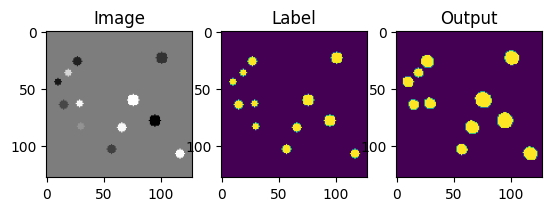



Number of training images = 16
Number of testing images = 40

----------
epoch 1/2
Loss: 0.7988 
Train dice: 0.5101
Test dice: 0.7126
Time: 3.7551
----------
epoch 2/2
Loss: 0.6612 
Train dice: 0.7300
Test dice: 0.7737
Time: 3.4924
Train completed, total time: 7.247460603713989.

Train metric = 0.7299717664718628, Test metric = 0.7737249135971069




<Figure size 640x480 with 0 Axes>

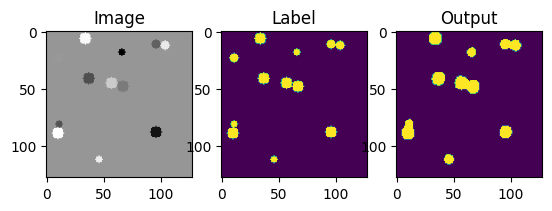



Number of training images = 32
Number of testing images = 40

----------
epoch 1/2
Loss: 0.6993 
Train dice: 0.6575
Test dice: 0.8121
Time: 5.3109
----------
epoch 2/2
Loss: 0.5176 
Train dice: 0.8475
Test dice: 0.9080
Time: 6.1403
Train completed, total time: 11.451216459274292.

Train metric = 0.8474565148353577, Test metric = 0.9079893231391907




<Figure size 640x480 with 0 Axes>

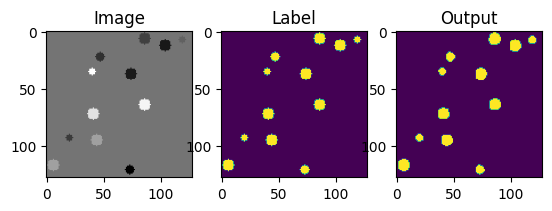



Number of training images = 64
Number of testing images = 40

----------
epoch 1/2
Loss: 0.6073 
Train dice: 0.7300
Test dice: 0.9121
Time: 8.2328
----------
epoch 2/2
Loss: 0.3438 
Train dice: 0.9130
Test dice: 0.9197
Time: 8.2436
Train completed, total time: 16.47647261619568.

Train metric = 0.9130176305770874, Test metric = 0.9197047352790833




<Figure size 640x480 with 0 Axes>

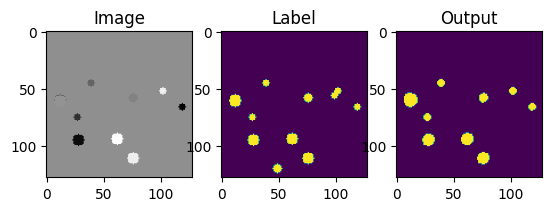



Number of training images = 128
Number of testing images = 40

----------
epoch 1/2
Loss: 0.4435 
Train dice: 0.8392
Test dice: 0.9686
Time: 14.0429
----------
epoch 2/2
Loss: 0.1444 
Train dice: 0.9703
Test dice: 0.9888
Time: 14.4031
Train completed, total time: 28.446015119552612.

Train metric = 0.970262885093689, Test metric = 0.9888326525688171




<Figure size 640x480 with 0 Axes>

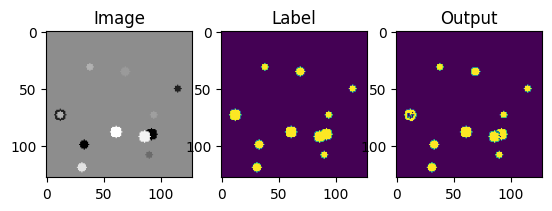



Number of training images = 256
Number of testing images = 40

----------
epoch 1/2
Loss: 0.2880 
Train dice: 0.9020
Test dice: 0.9891
Time: 26.3493
----------
epoch 2/2
Loss: 0.0616 
Train dice: 0.9868
Test dice: 0.9931
Time: 26.6035
Train completed, total time: 52.95282697677612.

Train metric = 0.9867647290229797, Test metric = 0.9931344985961914




<Figure size 640x480 with 0 Axes>

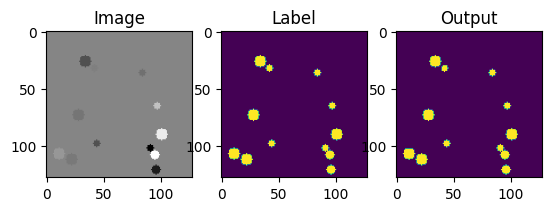

In [38]:
n_train_vec  = [8, 16, 32, 64, 128, 256]
n_test = 40

noise = 0
r_min = 3
r_max = 6

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max, n_train)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

ValueError: x and y must have same first dimension, but have shapes (6,) and (8,)

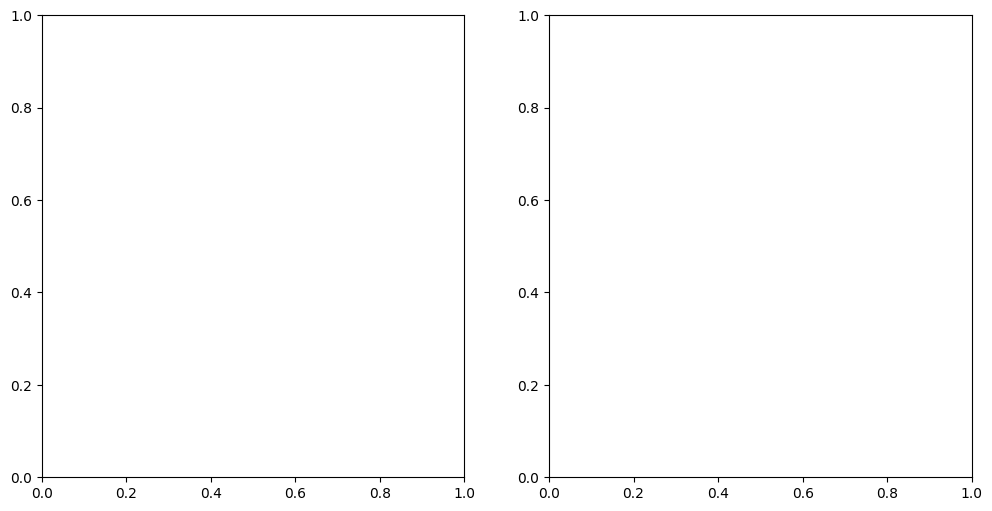

In [51]:
plot_train_dim(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)

## Noise


Noise = 0

----------
epoch 1/2
Loss: 0.5197 
Train dice: 0.8117
Test dice: 0.9181
Time: 8.3487
----------
epoch 2/2
Loss: 0.2981 
Train dice: 0.9383
Test dice: 0.9546
Time: 7.8022
Train completed, total time: 16.15089440345764.

Train metric = 0.9382613897323608, Test metric = 0.954554557800293




<Figure size 640x480 with 0 Axes>

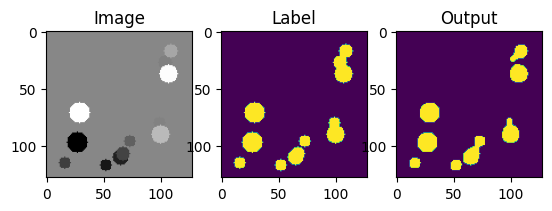



Noise = 0.3

----------
epoch 1/2
Loss: 0.5002 
Train dice: 0.8774
Test dice: 0.9835
Time: 8.3671
----------
epoch 2/2
Loss: 0.2723 
Train dice: 0.9839
Test dice: 0.9919
Time: 7.9579
Train completed, total time: 16.32502508163452.

Train metric = 0.9839063286781311, Test metric = 0.9919055700302124




<Figure size 640x480 with 0 Axes>

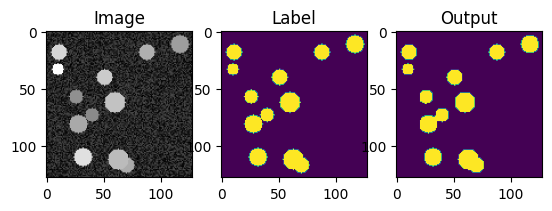



Noise = 0.6

----------
epoch 1/2
Loss: 0.5080 
Train dice: 0.8787
Test dice: 0.9594
Time: 8.0648
----------
epoch 2/2
Loss: 0.2837 
Train dice: 0.9672
Test dice: 0.9737
Time: 8.2091
Train completed, total time: 16.27392840385437.

Train metric = 0.9671612977981567, Test metric = 0.9737035632133484




<Figure size 640x480 with 0 Axes>

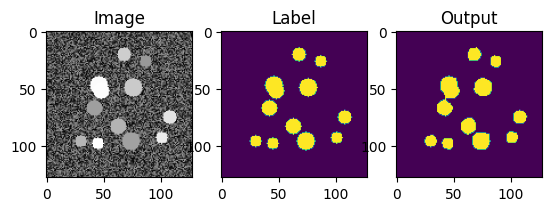



Noise = 0.9

----------
epoch 1/2
Loss: 0.5163 
Train dice: 0.8590
Test dice: 0.9496
Time: 7.9361
----------
epoch 2/2
Loss: 0.2941 
Train dice: 0.9483
Test dice: 0.9535
Time: 8.2980
Train completed, total time: 16.2341468334198.

Train metric = 0.9482988715171814, Test metric = 0.9534962773323059




<Figure size 640x480 with 0 Axes>

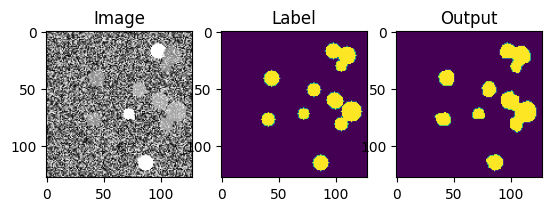



Noise = 1.2

----------
epoch 1/2
Loss: 0.5099 
Train dice: 0.8253
Test dice: 0.9183
Time: 8.4922
----------
epoch 2/2
Loss: 0.2989 
Train dice: 0.9294
Test dice: 0.9356
Time: 8.4605
Train completed, total time: 16.952704429626465.

Train metric = 0.9293537735939026, Test metric = 0.9355989694595337




<Figure size 640x480 with 0 Axes>

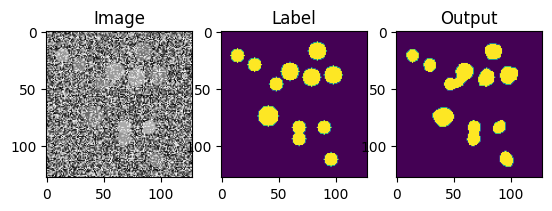



Noise = 1.5

----------
epoch 1/2
Loss: 0.5358 
Train dice: 0.7896
Test dice: 0.8802
Time: 8.3589
----------
epoch 2/2
Loss: 0.3164 
Train dice: 0.9045
Test dice: 0.9156
Time: 8.2753
Train completed, total time: 16.63422203063965.

Train metric = 0.9045056700706482, Test metric = 0.915589451789856




<Figure size 640x480 with 0 Axes>

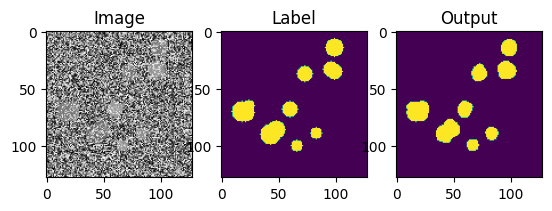



Noise = 1.8

----------
epoch 1/2
Loss: 0.5507 
Train dice: 0.7547
Test dice: 0.8607
Time: 7.8682
----------
epoch 2/2
Loss: 0.3359 
Train dice: 0.8741
Test dice: 0.8822
Time: 8.5561
Train completed, total time: 16.424392223358154.

Train metric = 0.8741189241409302, Test metric = 0.8821845054626465




<Figure size 640x480 with 0 Axes>

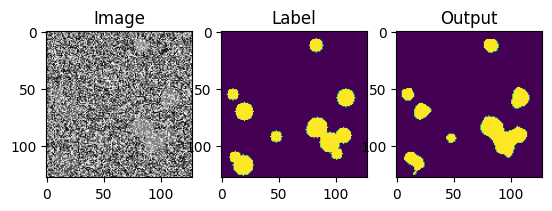



Noise = 2.1

----------
epoch 1/2
Loss: 0.5837 
Train dice: 0.7065
Test dice: 0.8199
Time: 7.9405
----------
epoch 2/2
Loss: 0.3743 
Train dice: 0.8262
Test dice: 0.8423
Time: 8.4831
Train completed, total time: 16.423606395721436.

Train metric = 0.8261557817459106, Test metric = 0.8422950506210327




<Figure size 640x480 with 0 Axes>

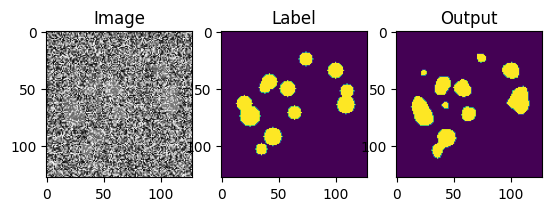

In [46]:
n_train = 60
n_test = 40

noise_vec = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]
r_min = 5
r_max = 10

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for noise in noise_vec:
  print()
  print(f"Noise = {noise}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max, int(10*noise) )
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

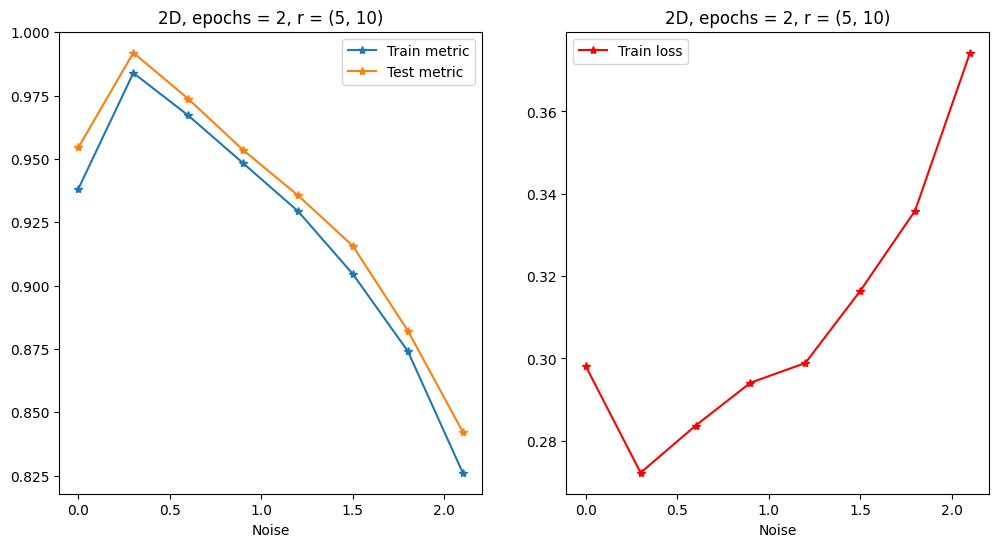

In [50]:
plot_noise(noise_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, max_epochs)